# Datasets

- __BARPA__:
    - Project py18 (moved from ia39 in 2024 Feb)
        - /g/data/py18/BARPA/...
        - 8 gcms, 6 frequencies, 183 variables
    - https://github.com/AusClimateService/BARPA-data-release/blob/main
    - BARPA is a downscaling method for future projections
        - BARPA-R is regional (17 km) model
        - BARPA-C is city scale (~1 km) and not as easily available?
    - 44TB per ssp folder
- __ERA5__:
    - ECMWF Reanalysis product, global product ~1960 onwards
    - project: rt52
    - directory: /g/data/rt52/era5/single-levels/reanalysis/
    - size: ~12GB for 2020, x37 levels for multiple level datasets
    - resolution: 0.25 degree resolution in netcdf files
    - 774 netcdf month files per variable


# BARPA

In [2]:
from glob import glob
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy
import importlib

## Put us in the right repo for local relative pathing
import os
__repo__="/g/data/en0/jwg574/repos/simple_fire_metric/"
os.chdir(__repo__)
import plotting, fio


In [2]:
from dask.distributed import Client
client = Client()
#display(client.proxy)
print(client.dashboard_link)

/proxy/8787/status


In [3]:
gcms = [
    ## evaluation/historical only
    "ERA5",
    "MPI-ESM1-2-HR", 
    ## with ssp projections:
    "CMCC-ESM2",
    "ACCESS-ESM1-5",
    "ACCESS-CM2", 
    "EC-Earth-Consortium-EC-Earth3",
    "CESM2", # was NCAR-CESM2
    "NorESM2-MM",
    ]
experiments = [
    "evaluation", # 1979-2020
    "historical", # 1960-2014
    "ssp126", # 2015-2100
    ## ssp126 seems to have been lost in transfer to py18
    "ssp370", # 2015-2100
    ]

gcm = gcms[2]
experiment = "ssp370"
realisation = "r1i1p1f1"
freq = "1hr"
var = "uas"

url_barpa_folder_base = fio.BARPA_base_url
print(url_barpa_folder_base)
url_barpa_folder = fio.BARPA_var_folder(var=var,gcm=gcm,experiment=experiment,realisation=realisation,freq=freq,)
print(url_barpa_folder)

/g/data/py18/BARPA/output/CMIP6/DD/AUS-15/BOM/%s/%s/%s/BARPA-R/v1-r1/%s/%s/%s/
/g/data/py18/BARPA/output/CMIP6/DD/AUS-15/BOM/CMCC-ESM2/ssp370/r1i1p1f1/BARPA-R/v1-r1/1hr/uas/v20231001/


In [4]:
print(url_barpa_folder)
url_barpa_varfiles = glob(url_barpa_folder+"*.nc")
url_barpa_varfiles.sort()
print("  - Contains %d netcdfs"%len(url_barpa_varfiles))
print("  - from: ",url_barpa_varfiles[0].split('/')[-1])
print("  - to:   ",url_barpa_varfiles[-1].split('/')[-1])

/g/data/py18/BARPA/output/CMIP6/DD/AUS-15/BOM/CMCC-ESM2/ssp370/r1i1p1f1/BARPA-R/v1-r1/1hr/uas/v20231001/
  - Contains 86 netcdfs
  - from:  uas_AUS-15_CMCC-ESM2_ssp370_r1i1p1f1_BOM_BARPA-R_v1-r1_1hr_201501-201512.nc
  - to:    uas_AUS-15_CMCC-ESM2_ssp370_r1i1p1f1_BOM_BARPA-R_v1-r1_1hr_210001-210012.nc


In [5]:
barpa_uas = xr.open_mfdataset(url_barpa_varfiles)


0.3.0


In [6]:
print(barpa_uas.dims)
print(barpa_uas.height)
print(barpa_uas.height.values)

FrozenMappingWarningOnValuesAccess({'time': 753360, 'lat': 436, 'lon': 777})
<xarray.DataArray 'height' ()>
array(10.)
Coordinates:
    height   float64 10.0
Attributes:
    standard_name:  height
    units:          m
    positive:       up
    long_name:      height
10.0


# Read year of BARPA
1. Read variables (optionally set gcm, experiment, etc...)
2. calculate FFDI
    - Requires Dewpoint Temperature

In [7]:
barpa = fio.BARPA_read_year(vars=['hurs','tas','ps','uas','vas'], year=2035)

INFO: reading hurs from /g/data/py18/BARPA/output/CMIP6/DD/AUS-15/BOM/CMCC-ESM2/ssp370/r1i1p1f1/BARPA-R/v1-r1/1hr/hurs/v20231001/hurs_AUS-15_CMCC-ESM2_ssp370_r1i1p1f1_BOM_BARPA-R_v1-r1_1hr_203501-203512.nc
INFO: reading tas from /g/data/py18/BARPA/output/CMIP6/DD/AUS-15/BOM/CMCC-ESM2/ssp370/r1i1p1f1/BARPA-R/v1-r1/1hr/tas/v20231001/tas_AUS-15_CMCC-ESM2_ssp370_r1i1p1f1_BOM_BARPA-R_v1-r1_1hr_203501-203512.nc
INFO: reading ps from /g/data/py18/BARPA/output/CMIP6/DD/AUS-15/BOM/CMCC-ESM2/ssp370/r1i1p1f1/BARPA-R/v1-r1/1hr/ps/v20231001/ps_AUS-15_CMCC-ESM2_ssp370_r1i1p1f1_BOM_BARPA-R_v1-r1_1hr_203501-203512.nc
INFO: reading uas from /g/data/py18/BARPA/output/CMIP6/DD/AUS-15/BOM/CMCC-ESM2/ssp370/r1i1p1f1/BARPA-R/v1-r1/1hr/uas/v20231001/uas_AUS-15_CMCC-ESM2_ssp370_r1i1p1f1_BOM_BARPA-R_v1-r1_1hr_203501-203512.nc
INFO: reading vas from /g/data/py18/BARPA/output/CMIP6/DD/AUS-15/BOM/CMCC-ESM2/ssp370/r1i1p1f1/BARPA-R/v1-r1/1hr/vas/v20231001/vas_AUS-15_CMCC-ESM2_ssp370_r1i1p1f1_BOM_BARPA-R_v1-r1_1hr_20

In [8]:
importlib.reload(fio)
barpa = fio.calc_Td(barpa,t='tas',rh='hurs')
barpa = fio.calc_DWI_V(barpa,d2m='Td',t2m='tas',u10='uas',v10='vas')
barpa = fio.calc_ffdi(barpa,d2m='Td',t2m='tas',u10='uas',v10='vas')

In [9]:
print(barpa['hurs'].height,barpa['vas'].height)

1.5 10.0


In [10]:
%%time
# quite slow: 1 minute 10 seconds for 100x100 spatial subset
# < 10 GB RAM
FFDI = barpa.FFDI[:,:100,:100].compute()
# doubled
TAS = barpa.tas[:,:100,:100].compute()


CPU times: user 2.35 s, sys: 1.64 s, total: 3.98 s
Wall time: 22 s


In [11]:
print(type(FFDI))

<class 'xarray.core.dataarray.DataArray'>


In [13]:
## monthly max, time stamp at End of month (ME)
da_ffdi_max = FFDI.resample(time='ME').max()
da_ffdi_resampled = FFDI.resample(time='ME')

da_tas_resampled = TAS.resample(time='ME')
## Getting index of daily maximum is not built in

Coordinates:
  * time     (time) object 2035-01-01 00:00:00 ... 2035-12-31 23:00:00
  * lat      (lat) float64 -53.58 -53.42 -53.27 -53.11 ... 13.32 13.48 13.63
  * lon      (lon) float64 88.04 88.19 88.34 88.5 ... 207.5 207.6 207.8 207.9
s10 ('time', 'lat', 'lon')
0  nans in each time slice


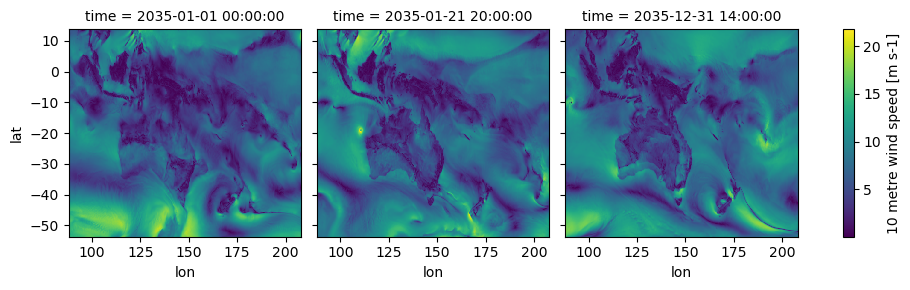

Td ('time', 'lat', 'lon')
0  nans in each time slice


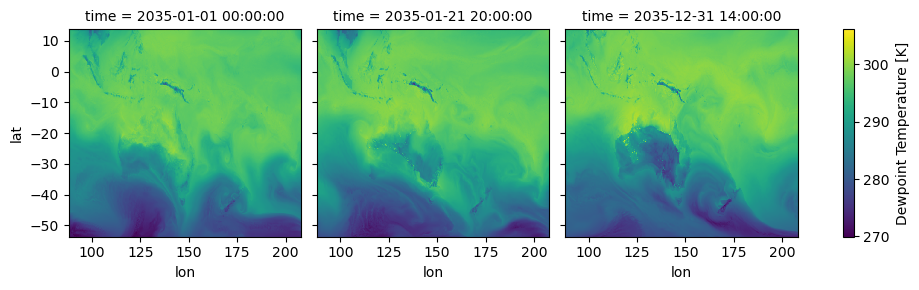

DWI_V ('time', 'lat', 'lon')
0  nans in each time slice


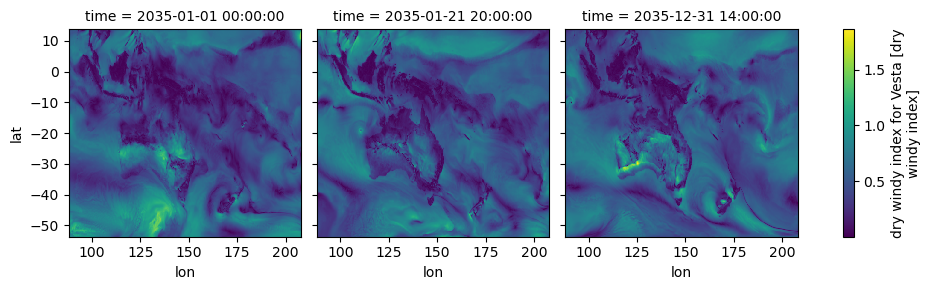

FFDI ('time', 'lat', 'lon')
0  nans in each time slice


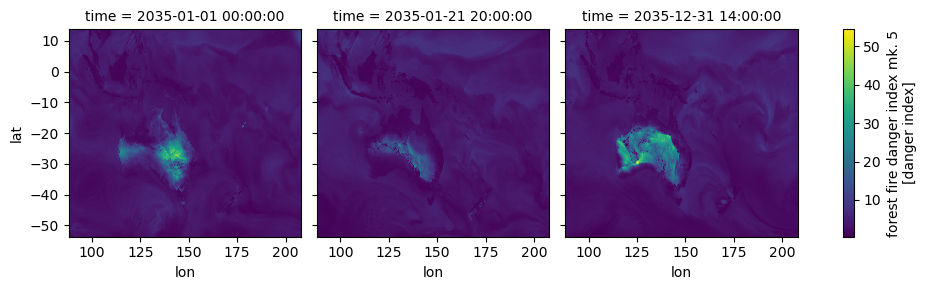

In [14]:
print(barpa['hurs'].coords)
for var in ['s10','Td','DWI_V','FFDI']:#'hurs','tas','ps','uas','vas',
    print(var, barpa[var].dims)
    icheck = [0,500,-10]
    print(np.sum(np.isnan(barpa[var].isel(time=0).values)), ' nans in each time slice')
    barpa[var].isel(time=icheck).plot(col='time')
    plt.show()

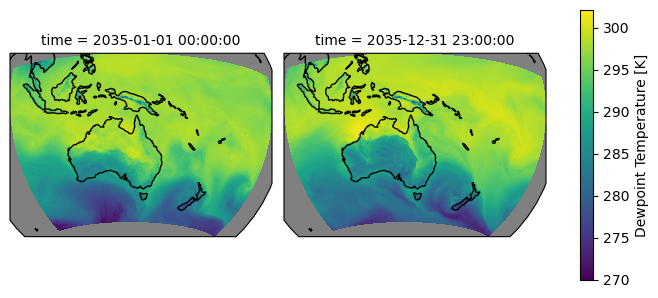

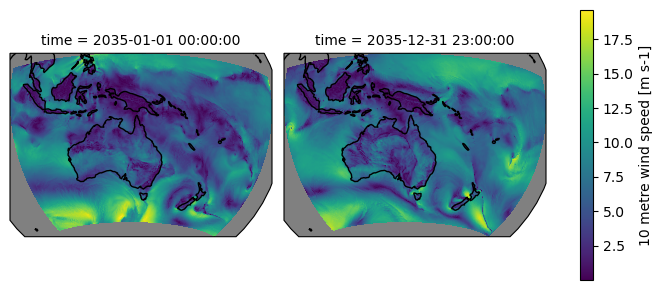

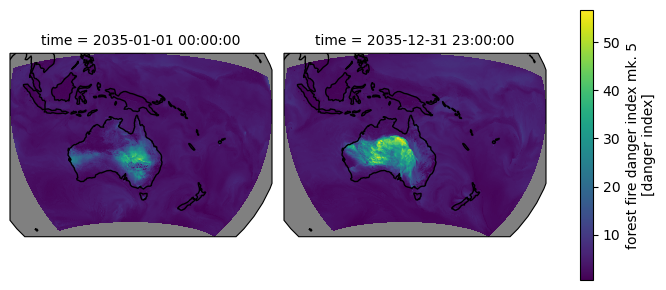

In [15]:
plotting.plot_quick(barpa['Td'],itimes=[0,-1])
plt.show()
plotting.plot_quick(barpa['s10'],itimes=[0,-1])
plt.show()
plotting.plot_quick(barpa['FFDI'],itimes=[0,-1])
plt.show()

# ERA5 Dataset
- __ERA5__:
    - ECMWF Reanalysis product, global product ~1960 onwards
    - project: rt52
    - directory: /g/data/rt52/era5/single-levels/reanalysis/
    - size: ~12GB for 2020, x37 levels for multiple level datasets
    - resolution: 0.25 degree resolution in netcdf files
    - 774 netcdf month files per variable



In [18]:
era5_vfolders = glob("/g/data/rt52/era5/single-levels/reanalysis/*")
era5_vfolders.sort()
print(era5_vfolders[:5])

['/g/data/rt52/era5/single-levels/reanalysis/100u', '/g/data/rt52/era5/single-levels/reanalysis/100v', '/g/data/rt52/era5/single-levels/reanalysis/10fg', '/g/data/rt52/era5/single-levels/reanalysis/10u', '/g/data/rt52/era5/single-levels/reanalysis/10v']


In [16]:
ds = fio.ERA5_read_month(['u10','v10','u10n','v10n','d2m','t2m'],'2019-12')

CPU times: user 171 ms, sys: 109 ms, total: 279 ms
Wall time: 930 ms


In [19]:
## add 10m wind magnitude
ds = fio.calc_s10(ds)
## add RH at 10m
ds = fio.calc_rh(ds)
## add FFDI mark 5
ds = fio.calc_ffdi(ds)

In [20]:
ds

<xarray.Dataset>
Dimensions:    (longitude: 1440, latitude: 321, time: 744)
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
  * latitude   (latitude) float32 20.0 19.75 19.5 19.25 ... -59.5 -59.75 -60.0
  * time       (time) datetime64[ns] 2019-12-01 ... 2019-12-31T23:00:00
Data variables:
    u10        (time, latitude, longitude) float32 dask.array<chunksize=(50, 321, 1440), meta=np.ndarray>
    v10        (time, latitude, longitude) float32 dask.array<chunksize=(50, 321, 1440), meta=np.ndarray>
    u10n       (time, latitude, longitude) float32 dask.array<chunksize=(50, 321, 1440), meta=np.ndarray>
    v10n       (time, latitude, longitude) float32 dask.array<chunksize=(50, 321, 1440), meta=np.ndarray>
    d2m        (time, latitude, longitude) float32 dask.array<chunksize=(50, 321, 1440), meta=np.ndarray>
    t2m        (time, latitude, longitude) float32 dask.array<chunksize=(50, 321, 1440), meta=np.ndarray>
    s10        (time, latitude, longitude) float32 dask.array<chunksize=(50, 321, 1440), meta=np.ndarray>
    rh2m       (time, latitude, longitude) float32 dask.array<chunksize=(50, 321, 1440), meta=np.ndarray>
    FFDI       (time, latitude, longitude) float32 dask.array<chunksize=(50, 321, 1440), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2020-09-26 13:14:07 UTC+1000 by era5_replication_tools-1.2....
    license:      Licence to use Copernicus Products: https://apps.ecmwf.int/...
    summary:      ERA5 is the fifth generation ECMWF atmospheric reanalysis o...
    title:        ERA5 single-levels reanalysis 10m_u_component_of_wind 20191...

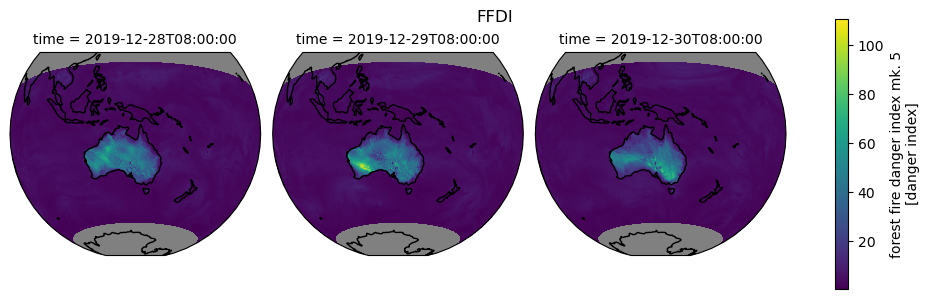

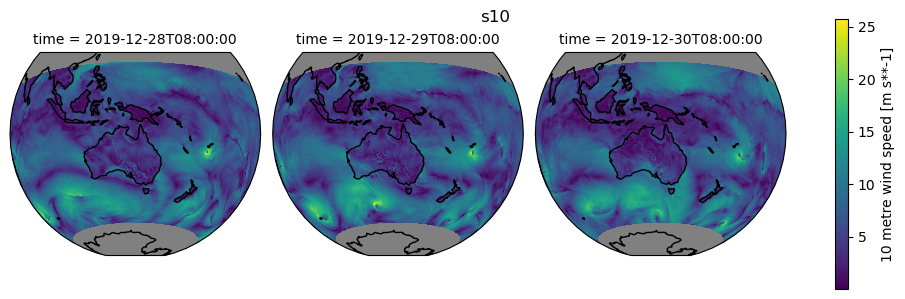

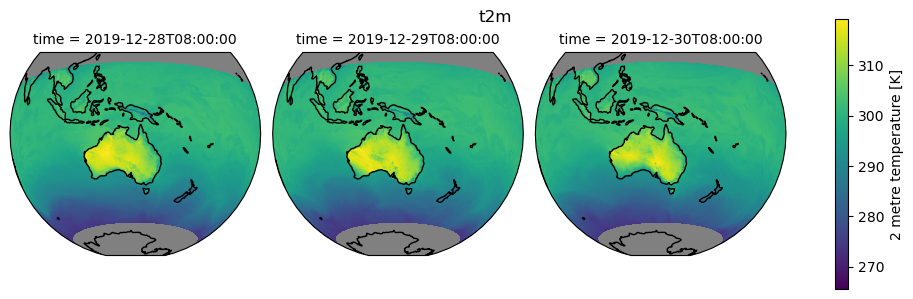

CPU times: user 6.64 s, sys: 369 ms, total: 7.01 s
Wall time: 14 s


In [21]:
%%time

# ~ 24 seconds for 5 variables, 4 times
for var in ['FFDI','s10','t2m']:#,'d2m','rh2m']:
    plotting.plot_quick(ds[var],itimes=[656,680,704])
    plt.suptitle(var);
    plt.show()
    

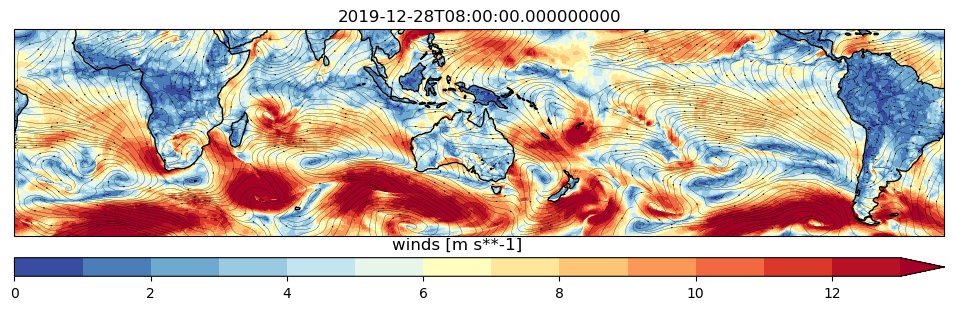

In [22]:
plt.rcParams['figure.figsize'] = [12, 7]
plotting.plot_winds(ds,itimes=[656])#,680,704])

## Mask Australia

In [24]:
importlib.reload(fio)

<module 'fio' from '/g/data/en0/jwg574/repos/simple_fire_metric/fio.py'>

(744, 155, 175)
(155, 175)


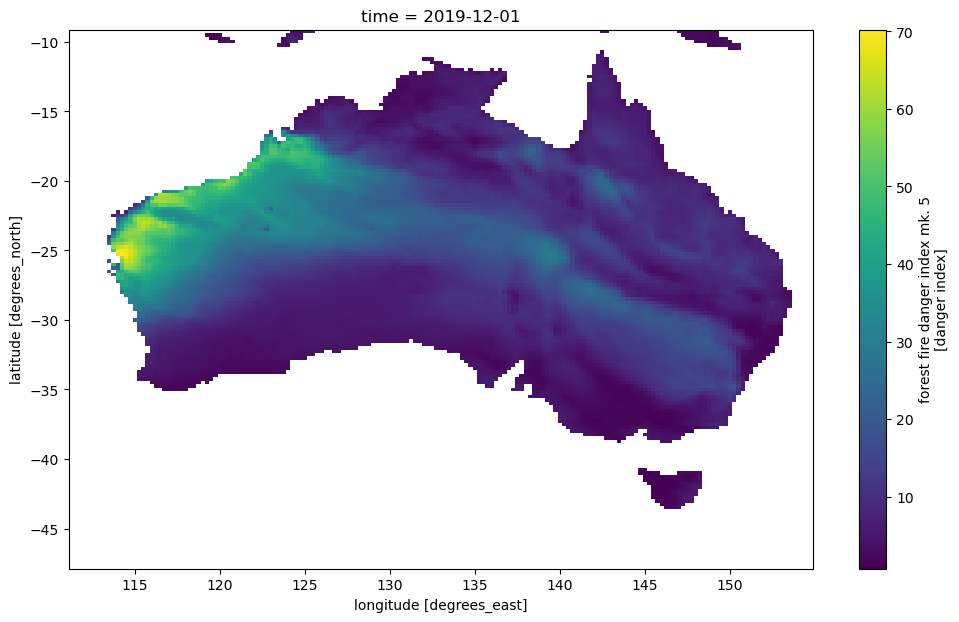

In [25]:
## First subset to AU area
ds = fio.select_australia(ds)

print(ds.FFDI.shape)
ausmask = fio.get_landmask(ds.FFDI)
print(ausmask.shape)
ds.FFDI.where(ausmask).isel(time=0).plot()

# BARRA
- project cj37
- /g/data/cj37/BARRA_R/...
    - 1990/01-2019/02
- 0.11 by 0.11 degree horizontal resolution
- Lats: 65 S to 19.4 N
- Lons: 65 to 197

### Notes
- winds at 10m 1990-2020 are ~ 42GB
    - Takes infinity minutes
    - I Haven't done the io work to read in this dataset
- just one year (2000) is much more managable
    - ~ 20 seconds to read 1 year of u10m
    - ~ 30 seconds to merge into single cube
- need to use chunking to enable underlying dask magic

In [10]:
import iris
from cartopy import crs as ccrs

In [3]:
dir_BARRA = "/g/data/cj37/BARRA/BARRA_R/v1/analysis/"

BARRA_daterange = pd.date_range('1990-01-01','2019-03-01',freq='6H')[:-1]
## Daily 0600Z time vector
BARRA_daterange_0600Z = BARRA_daterange[1::4]


In [14]:
paths_u10m_0600Z = glob(dir_BARRA+'slv/av_uwnd10m/**/**/*0600Z.nc')
paths_v10m_0600Z = glob(dir_BARRA+'slv/av_vwnd10m/**/**/*0600Z.nc')
paths_10mwinds_0600Z = paths_v10m_0600Z.copy()
paths_10mwinds_0600Z.extend(paths_u10m_0600Z)
paths_10mwinds_0600Z.sort()
print(len(paths_10mwinds_0600Z),"0600Z 10m u and v files in BARPA")

21302 0600Z 10m u and v files in BARPA


In [7]:
# iris.Future.datum_support=True ## don't know how to get rid of warning
# load in 'cubelist'
dewpt_scrn_sample = iris.load(dir_BARRA+'slv/dewpt_scrn/2018/11/dewpt_scrn-an-slv-PT0H-BARRA_R-v1-20181101T1200Z.nc')

/jobfs/111213124.gadi-pbs/ipykernel_4169934/3983109120.py:3: FutureWarning: Ignoring a datum in netCDF load for consistency with existing behaviour. In a future version of Iris, this datum will be applied. To apply the datum when loading, use the iris.FUTURE.datum_support flag.
  dewpt_scrn_sample = iris.load(dir_BARRA+'slv/dewpt_scrn/2018/11/dewpt_scrn-an-slv-PT0H-BARRA_R-v1-20181101T1200Z.nc')


In [8]:
print(dewpt_scrn_sample)

0: dew_point_temperature / (K)         (latitude: 768; longitude: 1200)


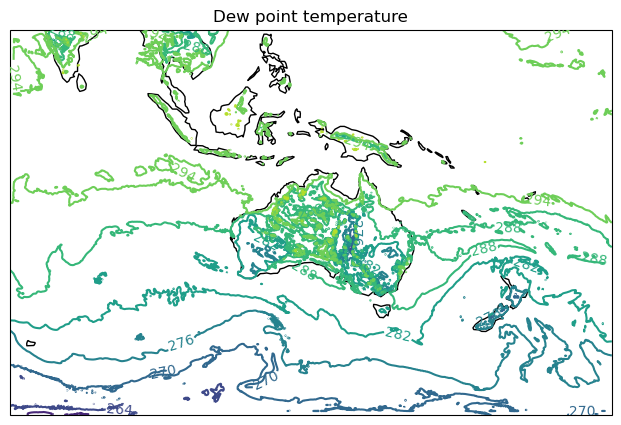

In [13]:
proj = ccrs.PlateCarree(central_longitude=-180.0)

fig = plt.figure(figsize=[10,5])
ax1= plt.subplot(111, projection=proj)
# plot the cube(first cube in cubelist)
contour = iris.quickplot.contour(dewpt_scrn_sample[0])
ax1.coastlines()
plt.clabel(contour,inline=True)
plt.show()

# ENSO 3.4
https://www.cpc.ncep.noaa.gov/data/indices/oni.ascii.txt

In [26]:
oni=fio.read_enso_rolling3m()


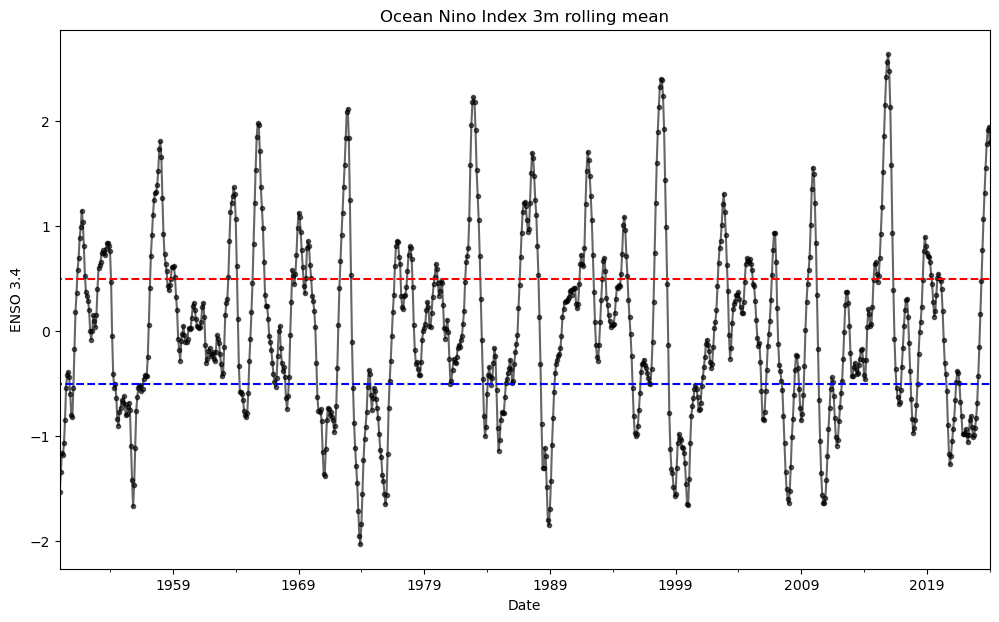

In [27]:
oni.ANOM.plot(c='k',marker='.',alpha=0.6)
plt.plot([oni.index.values[0],oni.index.values[-1]],[-.5,-.5],'b--')
plt.plot([oni.index.values[0],oni.index.values[-1]],[.5,.5],'r--')
plt.ylabel('ENSO 3.4')
plt.title('Ocean Nino Index 3m rolling mean');
